# TF Meetup: ASR with DNN

## Introduction  

In this notebook, you will build a Deep Neural Network (DNN) acoustic model for an Automatic Speech Recognition (ASR) pipeline, using TensorFlow! Your completed pipeline will accept a raw Arabic audio as input and return a predicted transcription using the Arabic language.

- **STEP 1** is a pre-processing step that converts raw audios to feature representations: Spectrograms and generates augmented datasets
- **STEP 2** is a modelling step that builds an acoustic model which accepts audio features as input and returns a probability distribution over all potential Arabic characters: A (CNN + RNN + TCT) model.
- **STEP 3** is an inference step that takes the output from the acoustic model and returns a predicted transcription.  


## STEP 1

### Audio Representation





**What is Sampling and Sampling frequency?**

**In signal processing, sampling is the reduction of a continuous signal into a series of discrete values. The sampling frequency or rate is the number of samples taken over some fixed amount of time. A high sampling frequency results in less information loss but higher computational expense, and low sampling frequencies have higher information loss but are fast and cheap to compute.**

**Example: Typically 16kHz for audio meaning samples are taken 16 000 times per second**

Python has some great libraries for audio processing like Librosa and PyAudio.There are also built-in modules for some basic audio functionalities.
We will mainly use two libraries for audio acquisition and playback

In [ ]:
# Load an audio file
import librosa
audio_data = '/content/TF_Meetup5.wav' # Path to the audio file
sample_rate = 16000
x , sr = librosa.load(audio_data, sr=sample_rate)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
# Digital audio files in .wav format
audio_duration = librosa.core.get_duration(filename=audio_data)
total_samples = sample_rate * audio_duration
print("Audio Duration = ", audio_duration)
print("Audio Sample Rate = ", sample_rate)
print("Total number of sample taken = ", int(total_samples))
print("Input Tensor size = ", len(x))

Audio Duration =  9.7175625
Audio Sample Rate =  16000
Total number of sample taken =  155481
Input Tensor size =  155481


Using IPython.display.Audio you can play the audio in your jupyter notebook.

In [ ]:
# Playing audio
import IPython.display as ipd
ipd.Audio(audio_data)

We can plot the audio array using librosa.display.waveplot:

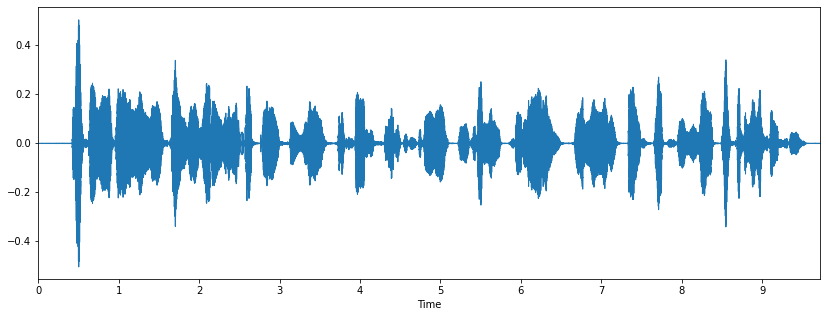

In [ ]:
# Visualizing audio
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

**A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.**

We can display a spectrogram using. librosa.display.specshow.

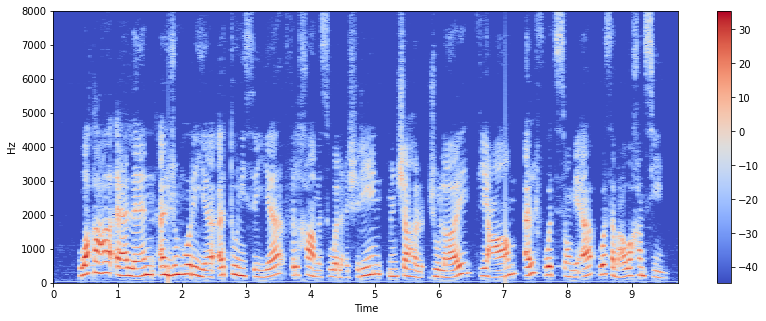

In [ ]:
# Diplay the spectrogram
X = librosa.stft(x) # The STFT represents a signal in the time-frequency domain
                    # by computing discrete Fourier transforms (DFT) over short
                    # overlapping windows.
Xdb = librosa.amplitude_to_db(abs(X)) # Convert an amplitude spectrogram to
                                      # dB-scaled spectrogram.
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
Xdb.shape

(1025, 304)

### Data augmentation

In [ ]:
!pip install WavAugment==0.2
!pip install nlpaug==1.1.3

     |████████████████████████████████| 1.9MB 31.5MB/s 
     |████████████████████████████████| 399kB 34.8MB/s 


In [ ]:
import torch
import torchaudio
import augment
import nlpaug.augmenter.audio as naa
import numpy as np

In [ ]:
x, sr = torchaudio.load(audio_data) # Load data as a torchaudio

In [ ]:
# Add noise
noise_generator = lambda: torch.zeros_like(x).uniform_() # Create a noise
y = augment.EffectChain().additive_noise(noise_generator, snr=15).apply(x, src_info={'rate': sr})
ipd.Audio(y, rate=sr)

In [ ]:
# Speech speed-down
aug = naa.SpeedAug(zone=(0,20),factor=(0.5, 1))
y = torch.Tensor(aug.augment(np.array(x.squeeze())))
ipd.Audio(y, rate=sr)

In [ ]:
# Speech speed-up
aug = naa.SpeedAug(zone=(0,20), factor=(1, 1.55))
y = torch.Tensor(aug.augment(np.array(x.squeeze())))
ipd.Audio(y, rate=sr)

In [ ]:
# Pitch up
y = augment.EffectChain().pitch(300).rate(sr).apply(x, src_info={'rate': sr})
ipd.Audio(y, rate=sr)

In [ ]:
# Pitch down
y = augment.EffectChain().pitch(-300).rate(sr).apply(x, src_info={'rate': sr})
ipd.Audio(y, rate=sr)

# STEP 2: [DeepAsr](https://github.com/scionoftech/DeepAsr) implemenattion of [DeepSpeech 2](https://arxiv.org/pdf/1512.02595.pdf)

In [ ]:
! pip install tensorflow==2.5.0
!pip install deepasr

# 1. Prepare Dataset

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import deepasr as asr

In [ ]:
# Read the dataset
path_dataset = "./path_to_your_dataset"
df = pd.read_csv(os.path.join(path_dataset,'train_manifest_deepasr.csv')

/content/drive/MyDrive/wav2vec-HF


In [ ]:
# Display some samples from the dataset
df.head()

,path,transcripts
0,preprocessed-mgb-2-data/test_data/wav/03BD00C0...,>hlA bkm m$AhdynA AlkrAm fy Hlqp jdydp mn brnA...
1,preprocessed-mgb-2-data/test_data/wav/03BD00C0...,ytHdv En AlbyE bAltqsyT whw nwE mn >nwAE Albyw...
2,preprocessed-mgb-2-data/test_data/wav/03BD00C0...,ytfq bmwjbh AlbA}E wAlm$try ElY kyfyp sdAd >vm...
3,preprocessed-mgb-2-data/test_data/wav/03BD00C0...,wkyfyp wTryqp AldfE wTbEA h*h AlZAhrp Ant$rt A...
4,preprocessed-mgb-2-data/test_data/wav/03BD00C0...,sn$rH tfASyl h*h AlEmlyp fy Hlqp Alywm HyAkm Allh


In [ ]:
#!pip install lang_trans

from lang_trans.arabic import buckwalter

example = ">hlA bkm m$AhdynA AlkrAm fy Hlqp jdydp mn brnAmj AlAqtSAd wAlnAs mwDwE HlqtnA lh*A Alywm"

buckwalter_to_arabic = buckwalter.untrans(example)
print(buckwalter_to_arabic)

أهلا بكم مشاهدينا الكرام في حلقة جديدة من برنامج الاقتصاد والناس موضوع حلقتنا لهذا اليوم


In [ ]:
# filter transcript less than 100 charcters
train_data = df[df['transcripts'].str.len() < 100]

# 2. Prepare DeepAsr CTC Pipeline

We will use DeepAsr implementation of DeepSpeech2. DeepAsr is an open source implementation of different Automatic Speech Recognition ASR architectures.

Supported Asr Architectures:

* Baidu's Deep Speech 2
* DeepAsrNetwork1

**Model Architecture**

Architecture is some 2D Convolutions, RNN layers, and Fully Connected layer.
<img src="https://miro.medium.com/max/700/1*4LR0aEk77p95R7TkAfE0CQ.png">

**Input Data**
Input data for this model is something called mel spectrogram of audio, which is kind of like feature vector.
<img src="https://miro.medium.com/max/2400/1*lSvGX3S8ZDerseyC5TfqSA.png"> 
the **feature count** is **161**. Horizontal axis is **time**. So the number is variable. Longer audio give you bigger number, shorter audio give you smaller number. **457** is just an example.

In [ ]:
import DeepAsr.deepasr as asr

/content/drive/MyDrive/wav2vec-HF


In [ ]:
# get CTCPipeline
def get_config(feature_type: str = 'spectrogram', multi_gpu: bool = False):
    # audio feature extractor
    features_extractor = asr.features.preprocess(feature_type=feature_type, features_num=161,
                                                 samplerate=16000,
                                                 winlen=0.02,
                                                 winstep=0.025,
                                                 winfunc=np.hanning)
    
    # input label encoder
    alphabet_en = asr.vocab.Alphabet(lang='ar')
    # training model
    model = asr.model.get_deepspeech2(
        input_dim=161, # the height of the spectrogram. With a sample rate 16KHz, conventionally we use 161 as input dim
        output_dim=55, # Number of our vocabulary
        is_mixed_precision=True
    )
    # model optimizer
    optimizer = tf.keras.optimizers.Adam(
        lr=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )
    # output label deocder
    decoder = asr.decoder.GreedyDecoder()
    # CTCPipeline
    pipeline = asr.pipeline.ctc_pipeline.CTCPipeline(
        alphabet=alphabet_en, features_extractor=features_extractor, model=model, optimizer=optimizer, decoder=decoder,
        sample_rate=16000, mono=True, multi_gpu=multi_gpu
    )
    return pipeline

In [ ]:
# CTCPiline for asr
pipeline = get_config(feature_type='spectrogram', multi_gpu=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 3. Model traning

In [ ]:
# train asr model
history = pipeline.fit(train_dataset = train_data, batch_size=256, epochs=500)

Model: "DeepAsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None, 161)]  0                                            
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, None, 161)    644         the_input[0][0]                  
__________________________________________________________________________________________________
Conv1D_1 (Conv1D)               (None, None, 512)    412672      BN_1[0][0]                       
__________________________________________________________________________________________________
CBN_1 (BatchNormalization)      (None, None, 512)    2048        Conv1D_1[0][0]                   
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
# save deepasr ctc pipeline
checkpoint_path = "path_to_checkpoints_folder"
pipeline.save(checkpoint_path)

# 4. Model testing

In [ ]:
# load saved ctc pipeline
#pipeline1 = asr.pipeline.load(checkpoint_path)

In [ ]:
# get testing audio and transcript from dataset
index = np.random.randint(train_data.shape[0])
data = train_data.iloc[index]
test_file = data[0]
test_transcript = data[1]
# Audio file
print("Audio File:",test_file)
# ground truth
print("Audio Transcription:", test_transcript)
print("Transcript length:",len(test_transcript))

Audio File: preprocessed-mgb-2-data/test_data/wav/1608B330-8FF4-4509-9802-AF5A133B9A51_utt_249.wav
Audio Transcription: lybyA tEtmd klyA ElY EA}dAt AlnfT Al*y hwt mEdlAt tSdyrh <lY >ql mn Alvlv
Transcript length: 73


In [ ]:
# predict labels
pred= pipeline.predict(test_file)
print(pred)

mysqt ttmd klya ly a}dat al>nft al*y hwh mdlat tsdrh hly >ql mn alhr


# Summary

* We have reached a better understanding of the techniques used to process speech in the deep learning framework.

* DeepSpeech 2 requires lots of training data to get good predictions. For the english it was trained on ~11k hours.

* So you need to train on a large dataset to get a good model.
In the case where you don't have enough data, you can test transfer learning from a language to another or try other architectures or training techniques.
